### Multiple filteraton level plotting using adjacency method

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import warnings

import invr

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Creating the test dataset

In [2]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
values = list(range(0, 16))
values_1 = [1,2,3,4,8,7,6,5,9,10,11,12,16,15,14,13]
values_3 = [1,5,3,16,14,2,15,4,7,13,8,9,12,10,11,6]
values_2 = list(range(1, 17))
df = pd.DataFrame({'FIPS': box_names, 'Value': values,'Value_1': values_1,'Value_2': values_2,'Value_3': values_3})

In [3]:
df

,FIPS,Value,Value_1,Value_2,Value_3
0,A,0,1,1,1
1,B,1,2,2,5
2,C,2,3,3,3
3,D,3,4,4,16
4,E,4,8,5,14
5,F,5,7,6,2
6,G,6,6,7,15
7,H,7,5,8,4
8,I,8,9,9,7
9,J,9,10,10,13


In [4]:
# Sorting the DataFrame based on the 'rate' column
df.sort_values(by='Value_2', inplace=True)

In [5]:
# Adding a new column 'new_ID' with ID values starting from zero
df['sortedID'] = range(len(df))

In [6]:
df = df[['FIPS','Value', 'sortedID', 'Value_2']]

In [7]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    box_name = row['FIPS']
    value = row['Value']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [8]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_4576/2838188260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = df.apply(calculate_square_coordinates, axis=1)


In [9]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [10]:
# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

In [11]:
gdf.sort_values(by='Value', inplace=True)

In [12]:
gdf

,FIPS,Value,sortedID,Value_2,geometry
0,A,0,0,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
1,B,1,1,2,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
2,C,2,2,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
3,D,3,3,4,"POLYGON ((3.000 0.000, 4.000 0.000, 4.000 1.00..."
4,E,4,4,5,"POLYGON ((0.000 1.000, 1.000 1.000, 1.000 2.00..."
5,F,5,5,6,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
6,G,6,6,7,"POLYGON ((2.000 1.000, 3.000 1.000, 3.000 2.00..."
7,H,7,7,8,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00..."
8,I,8,8,9,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00..."
9,J,9,9,10,"POLYGON ((1.000 2.000, 2.000 2.000, 2.000 3.00..."


#### Generate adjacent counties


In [13]:
def generate_adjacent_counties(dataframe,filtration_threshold):
    filtered_df = dataframe[dataframe['Value_2'] < filtration_threshold]

    # Perform a spatial join to find adjacent precincts
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

    # Filter the results to include only the adjacent states
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')

    # Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()

    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)

    adjacencies_list = adjacent_counties['adjacent'].tolist()

    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county',right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

    return adjacencies_list,merged_df



In [14]:
adjacencies_list,adjacent_counties_df = generate_adjacent_counties(gdf,17)

In [15]:
adjacent_counties_df

,county,adjacent,FIPS,Value,sortedID,Value_2,geometry
0,0,"[1, 4, 5]",A,0,0,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
1,1,"[0, 4, 5, 2, 6]",B,1,1,2,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
2,2,"[1, 5, 3, 7, 6]",C,2,2,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
3,3,"[2, 7, 6]",D,3,3,4,"POLYGON ((3.000 0.000, 4.000 0.000, 4.000 1.00..."
4,4,"[0, 1, 5, 8, 9]",E,4,4,5,"POLYGON ((0.000 1.000, 1.000 1.000, 1.000 2.00..."
5,5,"[0, 1, 4, 8, 9, 2, 6, 10]",F,5,5,6,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
6,6,"[1, 5, 9, 3, 2, 7, 11, 10]",G,6,6,7,"POLYGON ((2.000 1.000, 3.000 1.000, 3.000 2.00..."
7,7,"[3, 2, 6, 11, 10]",H,7,7,8,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00..."
8,8,"[4, 5, 9, 12, 13]",I,8,8,9,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00..."
9,9,"[4, 5, 8, 12, 13, 6, 10, 14]",J,9,9,10,"POLYGON ((1.000 2.000, 2.000 2.000, 2.000 3.00..."


In [16]:
def form_simplicial_complex(adjacent_county_list):
    max_dimension = 3

    V = []
    V = invr.incremental_vr(V, adjacent_county_list, max_dimension)

    return V
    

In [17]:
V = form_simplicial_complex(adjacencies_list)

In [18]:
def fig2img(fig):
     #convert matplot fig to image and return it

     buf = io.BytesIO()
     fig.savefig(buf)
     buf.seek(0)
     img = Image.open(buf)
     return img

In [19]:
def plot_simplicial_complex(dataframe,V,list_gif):

    #city centroids
    city_coordinates = {city.sortedID: np.array((city.geometry.centroid.x, city.geometry.centroid.y)) for _, city in dataframe.iterrows()}

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_axis_off() 

    # Plot the "wyoming_svi" DataFrame
    dataframe.plot(ax=ax, edgecolor='black', linewidth=0.3, color="white")

    # Plot the centroid of the large square with values
    for i, row in dataframe.iterrows():
        centroid = row['geometry'].centroid
        text_to_display = f"FIPS: {row['FIPS']}\nFilteration: {row['Value_2']}"
        # plt.text(centroid.x, centroid.y, str(row['FIPS']), fontsize=15, ha='center', color="black")
        plt.text(centroid.x, centroid.y, text_to_display, fontsize=15, ha='center', color="black")

    i=0
    for edge_or_traingle in V:

        
        if len(edge_or_traingle) == 2:
            # Plot an edge
            ax.plot(*zip(*[city_coordinates[vertex] for vertex in edge_or_traingle]), color='red', linewidth=2)
            #img = fig2img(fig)
            #list_gif.append(img)
            # save the image
            plt.savefig(f'resullts/test2/frame_{i}.png') 

        elif len(edge_or_traingle) == 3:
            # Plot a triangle
            ax.add_patch(plt.Polygon([city_coordinates[vertex] for vertex in edge_or_traingle], color='green', alpha=0.2))
            #img = fig2img(fig)
            #list_gif.append(img)
            plt.savefig(f'resullts/test2/frame_{i}.png') 

    plt.close()

    return list_gif


In [20]:
list_gif = []

FileNotFoundError: [Errno 2] No such file or directory: '/results/test2/e0.png'

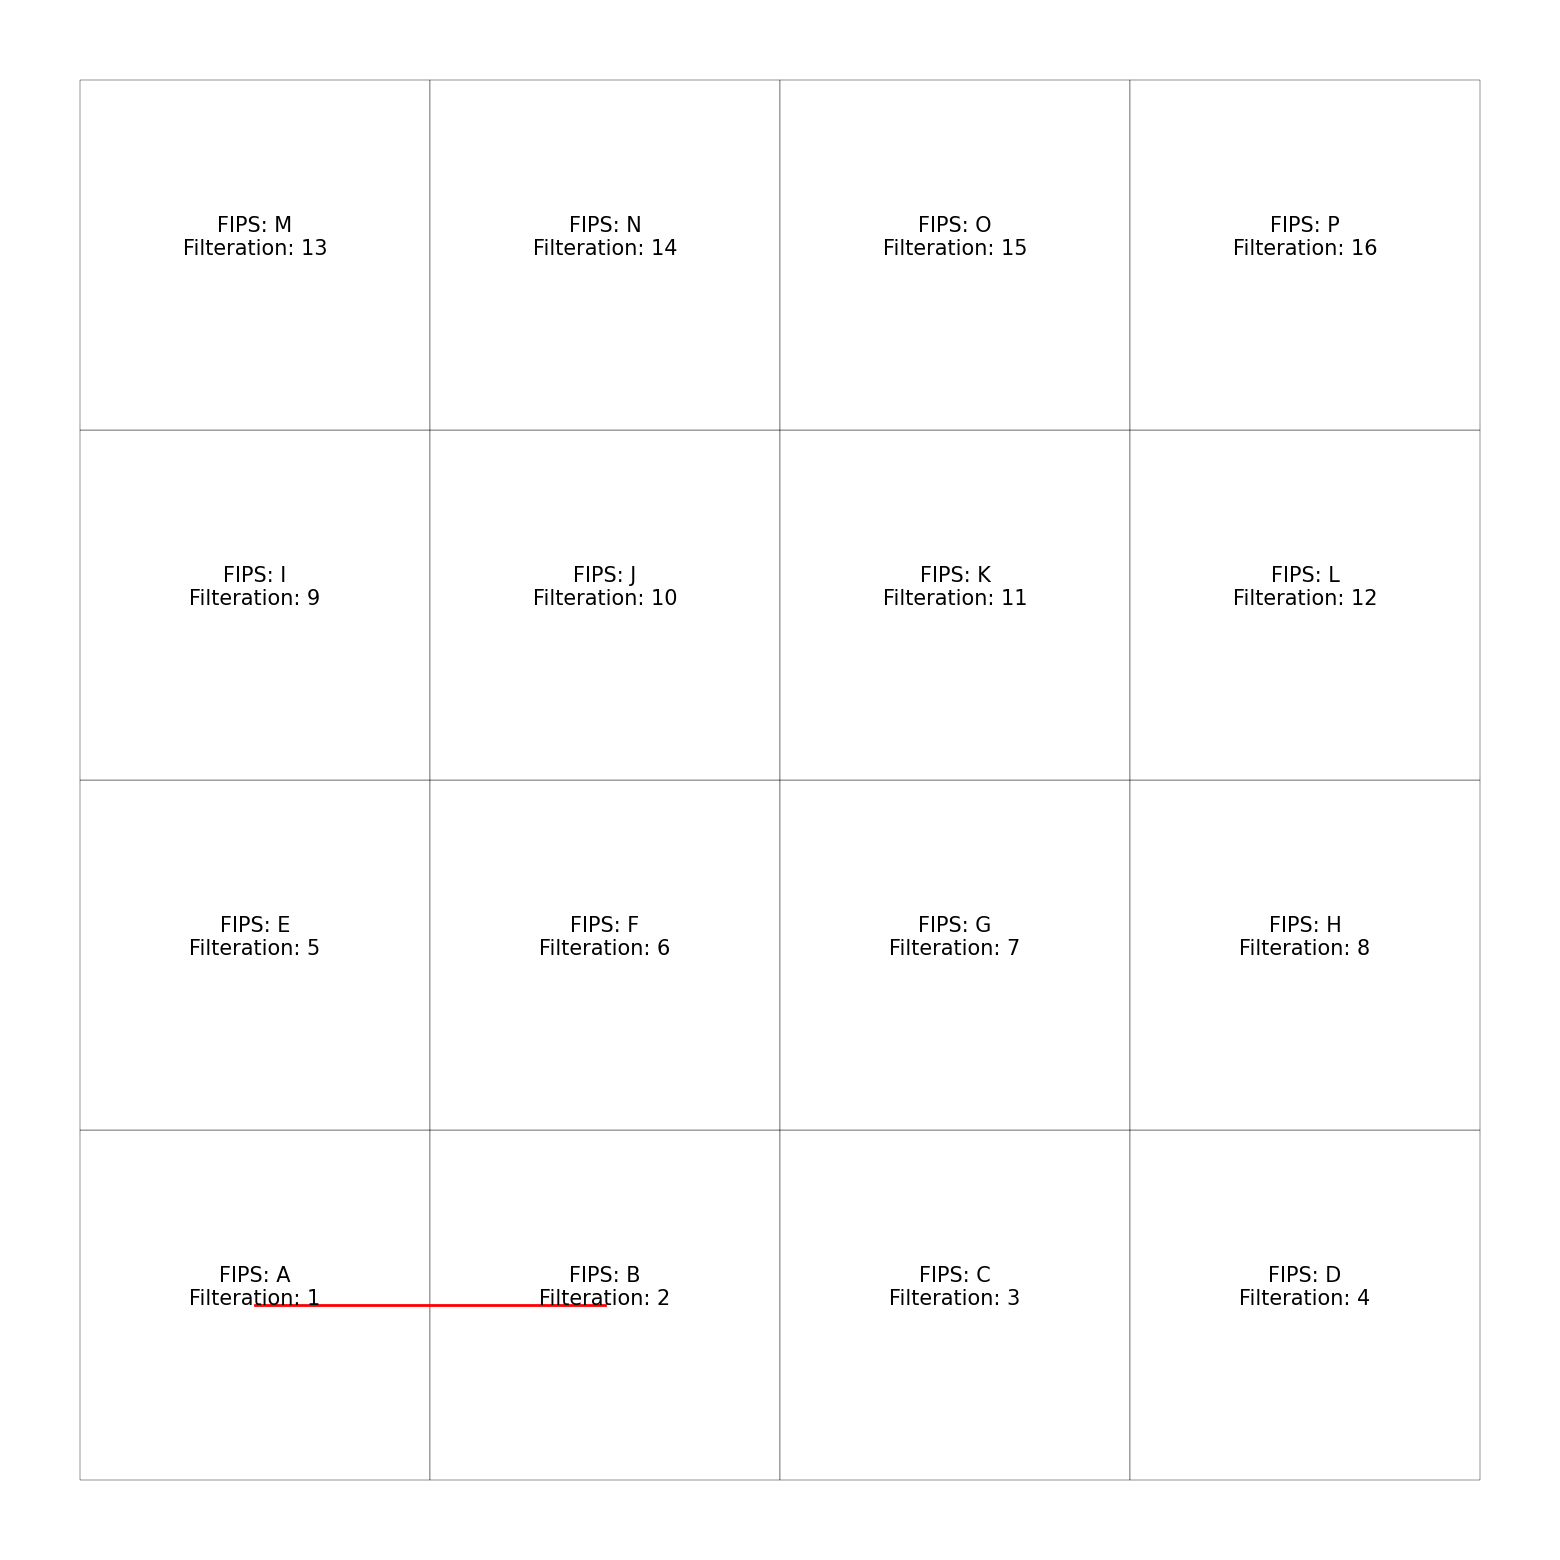

In [21]:
list_gif = plot_simplicial_complex(adjacent_counties_df,V,list_gif)

In [ ]:
list_gif[0].save('value_2.gif',
                 save_all=True,append_images=list_gif[1:],optimize=False,duration=3000,loop=0)